<h1>Image Registration</h1>
<dl>Image registration is the process of integrateing a set of images into a single image based on common features.
It is used in computer vision, medical images, etc...<br>
I used in this code SIFT (The scale-invariant feature transform) which is a computer vision algorithm to detect, describe,
and match local features in images, invented by David Lowe in 1999.
</dl>

In [1]:
#import libs
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os

In [2]:
#master class
class registor:
    def __init__(self):
        self.SIFT = cv2.xfeatures2d.SIFT_create()
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=0, trees=5)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)

    def __match(self, i1, i2):
        imageSet1 = self.__getSIFTFeatures(i1)
        imageSet2 = self.__getSIFTFeatures(i2)
        matches = self.flann.knnMatch(
            imageSet2['des'],
            imageSet1['des'],
            k=2
            )
        good = []
        for i , (m, n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                good.append((m.trainIdx, m.queryIdx))

        if len(good) > 4:
            pointsCurrent = imageSet2['kp']
            pointsPrevious = imageSet1['kp']

            matchedPointsCurrent = np.float32(
                [pointsCurrent[i].pt for (__, i) in good]
            )
            matchedPointsPrev = np.float32(
                [pointsPrevious[i].pt for (i, __) in good]
                )

            H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev, cv2.RANSAC, 4)
            return H
        return None

    def __getSIFTFeatures(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, des = self.SIFT.detectAndCompute(gray, None)
        return {'kp':kp, 'des':des}
    
    
    def register(self,extra,src):
        if sum(extra.shape) < sum(src.shape):
            temp = src
            src = extra
            extra = temp
            
        H = self.__match(src,extra)
        xh = np.linalg.inv(H)
        f1 = np.dot(xh, np.array([0,0,1]))
        f1 = f1/f1[-1]
        xh[0][-1] += abs(f1[0])
        xh[1][-1] += abs(f1[1])
        offsety = abs(int(f1[1]))
        offsetx = abs(int(f1[0]))
        dsize = int(np.sqrt((src.shape[0]**2)+(src.shape[1]**2)) + np.sqrt((extra.shape[0]**2)+(extra.shape[1]**2)))
        print("dsize",dsize)
        tmp = cv2.warpPerspective(src, xh, (dsize,dsize))
        print("tmp",tmp.shape)
        tmp[offsety:extra.shape[0]+offsety, offsetx:extra.shape[1]+offsetx] = extra
        tmp = self.__cutspace(tmp)
        return  tmp
 

    def __cutspace(self,img):
        flag = True
        while flag:
            if not img[:1,:].any():
                img = img[1:,:]
            if not img[:,:1].any():
                img = img[:,1:]
            if not img[-1:,:].any():
                img = img[:-1,:]
            if not img[:,-1:].any():
                img = img[:,:-1]
            if img[:1,:].any() and img[:,:1].any() and img[-1:,:].any() and img[:,-1:].any():
                flag = False
        return img

In [15]:
#load images from local folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.cvtColor(cv2.imread(os.path.join(folder,filename)), cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [16]:
#read my images 
path = "/home/anas/Pictures/used to use/registeration"
imgs = load_images_from_folder(path)

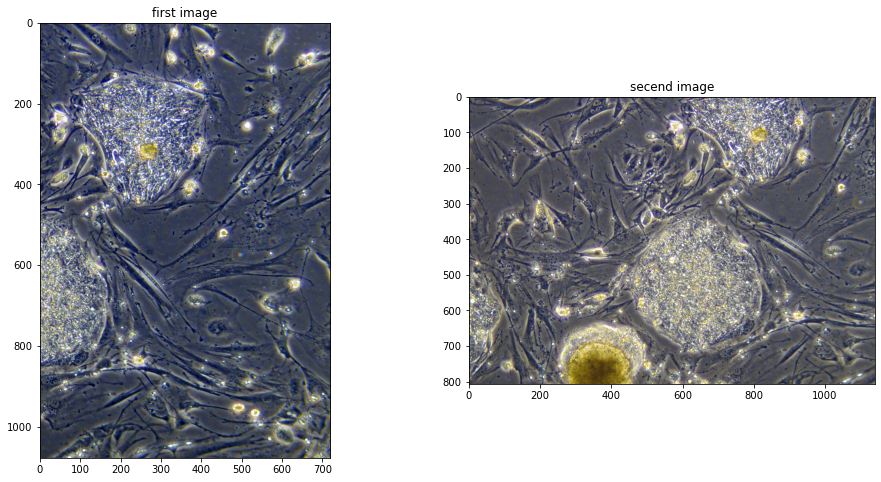

In [17]:
#display images which I want to register
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1, 2, 1)
plt.title("first image")
plt.imshow(imgs[0])
fig.add_subplot(1, 2, 2)
plt.title("secend image")
plt.imshow(imgs[1])
plt.show()

In [18]:
#create instance from my register class
reg = registor()

In [19]:
# do the registeration process on my images
result = reg.register(imgs[0],imgs[1])

dsize 2692
tmp (2692, 2692, 3)


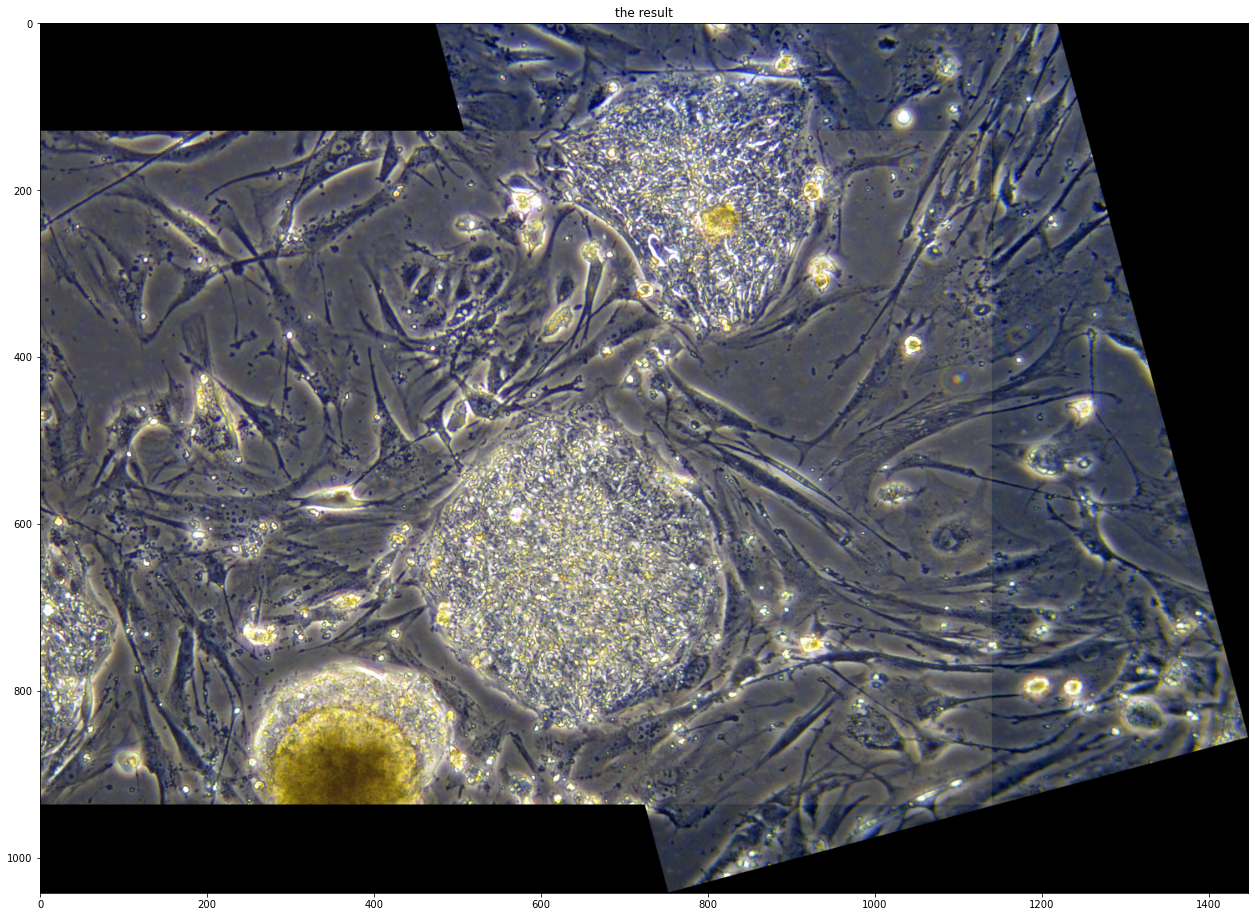

In [20]:
#display the result of registeration
plt.figure(figsize=(32,16))
plt.title("the result")
plt.imshow(result)
plt.show()